***Welcome! Hello!***

We are glad you're here 👏! And are excited to get you started 🚦!

This notebook exists to enable you to send some CAN messages (and log at the same time).

# How To Use

It does this with `python` BUT don't worry: you don't need to know `python` to use this notebook.

Start by running the cells (the jupyter name for these boxes 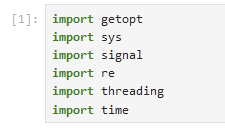).

Run all cells in both *1. Basic Imports* and *2. Scapy Setup* sections below:
1. click the cell
2. click the run button 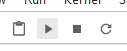 (or shift+enter)

Then move to the *Do the thing:* section and run those cells too 🚀!

(For the lazy / impatient: you can also run all the cells with the ⏩ button on the toolbar).

## 1. Basic Imports

In [ ]:
import getopt
import sys
import signal
import re
import threading
import time

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import binascii
import pandas as pd
import qgrid

qgrid.enable()

## 2. `scapy` Setup

We've done the basic imports. Now we need to setup `scapy` automotive CAN stuff.

Just like in a `scapy` interactive session [documented here](https://scapy.readthedocs.io/en/latest/layers/automotive.html) the statements in the following cell will work to get the right stuff imported for use here in this notebook.

In [ ]:
from scapy.all import *

load_layer("can")
conf.contribs['CANSocket'] = {'use-python-can': True}
load_contrib('cansocket')

(you may get a warning about wireshark stuff, don't worry about it)

# Do the thing: CAN Send (and log)

Same as before (in `easy_log.ipynb`) the next part of the notebook lets you change settings and capture CAN bus messages. Run the cell and you'll see a simple control panel:

* interface: This tells the notebook how to connect to your CAN device.
* channel: This is like the address of the specific CAN device, for slcan this is always a COM port e.g. `COM27` on Windows, `/dev/ttyUSB0` on Linux, or `/dev/cu.usbserial` on macOS.
* count: How many messages you want to capture. It can't save more than 1000, but you can change that limit. For your first test, you might want a smaller number than the default.
* send_can_msgs: set to the list of messages (hex_id#hex_data) you want to send

Change the settings, then click 'Run Interact'.

This one prints in **'candump format.'**


In [ ]:
def candump_print(pkt, interface, channel):
    print(
        f'({pkt.time:010.06f}) {interface}{channel} {pkt.identifier:03x}#{pkt.data.hex().ljust(18)}  ; {str(pkt.data)}',
        file=sys.stderr, flush=True)


def send_can_msg(csock, send_data):
    idn, data = send_data.split('#')
    pkt = CAN(identifier=int(idn, 16), data=binascii.unhexlify(data))
    csock.send(pkt)


@interact_manual
def canlog(interface='slcan', channel='COM29', count=(0, 1000, 4),
           send_data_msgs=widgets.Textarea('777#0102030405060708, 777#090a0b0c0d0e0f10',
                                           layout=widgets.Layout(width='100%', height='60px'))):
    with CANSocket(interface=interface, channel=channel) as csock:
        for data_msg in send_data_msgs.split(','):
            send_can_msg(csock, data_msg)
        sniff(count=count, opened_socket=csock,
              prn=lambda pkt: candump_print(pkt, interface, channel))

you may get warnings about "SocketWrapper was not properly shut down"; that's ok

---

This next one will display an **interactive table** of the captured CAN frames.

Same as above: run the cell and then you can adjust the interface, channel, and count settings and repeat the capture with the `run interact` button.

In [ ]:
def send_can_msg(csock, send_data):
    idn, data = send_data.split('#')
    pkt = CAN(identifier=int(idn, 16), data=binascii.unhexlify(data))
    csock.send(pkt)


@interact_manual
def canlog(interface='slcan', channel='COM29', count=(0, 1000, 4),
           send_data_msgs=widgets.Textarea('777#0102030405060708, 777#090a0b0c0d0e0f10',
                                           layout=widgets.Layout(width='100%', height='60px'))):
    with CANSocket(interface=interface, channel=channel) as csock:
        for data_msg in send_data_msgs.split(','):
            send_can_msg(csock, data_msg)
        frames_list = sniff(count=count, opened_socket=csock)
        df = pd.DataFrame({
            'time': [getattr(pkt, 'time') for pkt in frames_list],
            'id': [getattr(pkt, 'identifier') for pkt in frames_list],
            'id_hex': [f'{pkt.identifier:03x}' for pkt in frames_list],
            'data': [getattr(pkt, 'data') for pkt in frames_list],
            'data_hex': [getattr(pkt, 'data').hex() for pkt in frames_list]
        })

    display(df)

you may get warnings about "SocketWrapper was not properly shut down"; that's ok

if you have problems with missing imports, try uncommenting these and running the cell. These commands to install any missing packages and configure the interactive notebook extensions

In [ ]:
# !{sys.executable} -m pip install -r requirements.txt

# !{sys.executable} -m jupyter nbextension enable --py widgetsnbextension